# Energy-based parser

Muezzinoglu & Zurada (2006) present a radial basis function network for classification. The idea is quite intuitive: "store" a set of activation patterns in some state space using an energy function that is the sum of the RBFs for each pattern. The dynamics on the state space are then given by the gradient of the energy function. They show that the dynamics maxize the energy, seeking out the nearest maximum (pattern) to the initial conditions.

I propose to extend this to sentence processing in two ways. First, I will add noise so that it is possible to move from one energy maximum to another (simulated annealing might be necessary; see Smolensky's work...). Second, I will add input (from a sentence) that pushes the state of the system toward other saved patterns.

To apply this to sentence processing, the patterns stored correspond to link strengths, with each link having its own dimension. For now at least, each partial parse corresponds to a different stored pattern. The input to the system will be a vector whose elements on each dimension are the feature match values for that link. This input vector will contain zeros on each dimension except for those dimensions corresponding to the current word's links.

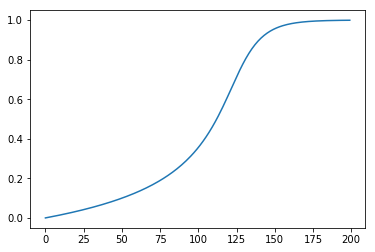

In [67]:
# Trying out a 1D version first
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt


def l2norm(x):
    return np.sqrt(x * x)


def rbf(x, c, gamma):
    phi = np.exp(-l2norm(x-c)**2/gamma)
    return phi

def dyn(x, c, gamma):
    dx = (-2./gamma) * (x - c) * rbf(x, c, gamma)
    return dx

tlen = 200
x = np.zeros(tlen)
tau = 0.01
for t in range(1, tlen):
    x[t] = x[t-1] + tau * dyn(x[t-1], 1., 0.25)

plt.plot(x)

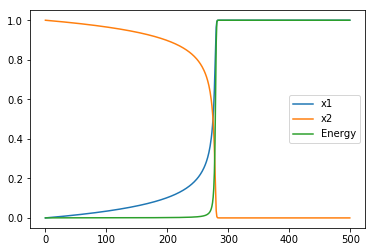

In [68]:
# Trying out a 2D version
def l2norm(x):
    return np.sqrt(x @ x)

ndim = 2
tlen = 500
c = np.array([1., 0])
x = np.zeros((tlen, ndim))
x[0,] = [0, 1.]
#x[0,] = [0.5]*ndim
tau = 0.1
e = np.zeros(tlen)
for t in range(1, tlen):
    x[t] = x[t-1] + tau * dyn(x[t-1], c, 0.25)
    e[t] = rbf(x[t-1], c, 0.25)

plt.plot(x)
plt.plot(e)
plt.legend(['x1', 'x2', 'Energy'])
plt.show()

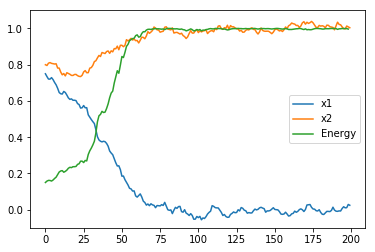

In [71]:
# Multiple patterns in 2D

# Redefining dyn to add in sum of RBFs; assumes c is a list
def dyn(x, c, gamma):
    dx = (-2./gamma) * (x - c[0]) * rbf(x, c[0], gamma) + (-2./gamma) * (x - c[1]) * rbf(x, c[1], gamma)
    return dx

tlen = 200
c0 = np.array([1., 0])
c1 = np.array([0., 1])
cs = [c0, c1]
x = np.zeros((tlen, ndim))
x[0,] = [0.75, 0.8]
tau = 0.01
e = np.zeros(tlen)
for t in range(1, tlen):
    x[t] = x[t-1] + tau * dyn(x[t-1], cs, 0.25) + np.sqrt(tau)*np.random.normal(0, 0.1, ndim)
    e[t-1] = rbf(x[t-1], cs[0], 0.25) + rbf(x[t-1], cs[1], 0.25)

plt.plot(x)
plt.ylim(-0.1, 1.1)
plt.plot(np.trim_zeros(e))
plt.legend(['x1', 'x2', 'Energy'])
plt.show()

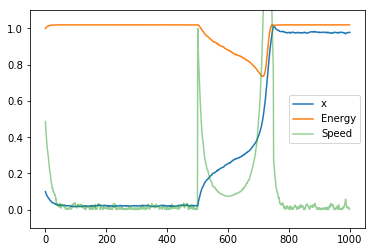

0.978770653902


In [72]:
# Ok, so far, so good
# Going back to 1D to test input

def l2norm(x):
    return np.sqrt(x * x)

def dyn(x, c, gamma, ipt):
    xhat = x - ipt
    dx = (-2./gamma) * (x - c[0]) * rbf(x, c[0], gamma) + (-2./gamma) * (x - c[1]) * rbf(x, c[1], gamma) + ipt
    #dx = (-2./gamma)*(x - c[0])*rbf(x, c[0], gamma) + (-2./gamma)*(x - c[1])*rbf(x, c[1], gamma) + ipt*x
    #dx = (-2./gamma) * (xhat - c[0]) * rbf(xhat, c[0], gamma) + (-2./gamma) * (xhat - c[1]) * rbf(xhat, c[1], gamma)
    return dx

def speed(x, c, gamma, ipt):
    vel = dyn(x, c, gamma, ipt)
    return np.sqrt(vel * vel)

ndim = 1
cs = np.array([1., 0])
tlen = 1000
x = np.zeros(tlen)
x[0,] = 0.1
e = np.zeros(tlen)
speeds = np.zeros(tlen)
tau = 0.01
ipt = 1.  # Input has to be of some minimum strength
gamma = 0.25
for t in range(1, tlen):
    if t < tlen//2:
        x[t] = x[t-1] + tau * dyn(x[t-1], cs, gamma, 0) + np.sqrt(tau)*np.random.normal(0, 0.01)
        speeds[t-1] = speed(x[t-1], cs, gamma, 0)
    elif tlen//2 < t < tlen//2 + 250: # just adding the input to the dyn needs longer "pulse"
        x[t] = x[t-1] + tau * dyn(x[t-1], cs, gamma, ipt) + np.sqrt(tau)*np.random.normal(0, 0.01)
        speeds[t-1] = speed(x[t-1], cs, gamma, ipt)
    else:
        x[t] = x[t-1] + tau * dyn(x[t-1], cs, gamma, 0) + np.sqrt(tau)*np.random.normal(0, 0.01)
        speeds[t-1] = speed(x[t-1], cs, gamma, 0)
    e[t-1] = rbf(x[t-1], cs[0], gamma) + rbf(x[t-1], cs[1], gamma)

plt.plot(x)
plt.plot(np.trim_zeros(e))
plt.plot(np.trim_zeros(speeds), alpha=0.5)
plt.ylim(-0.1, 1.1)
plt.legend(['x', 'Energy', 'Speed'])
plt.show()
print(x[-1])

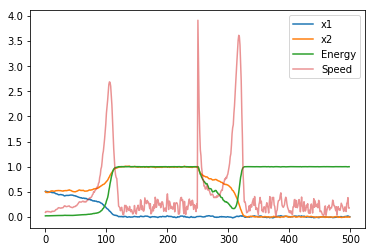

In [156]:
# Now the big test: handling inputs in 2D w/ two patterns
# Also want to add weights to make better feature matches have higher energy/harmony peaks

def l2norm(x):
    return np.sqrt(x @ x)

def dyn(x, c, gamma, ipt):
    #xhat = x - ipt
    #xhat = ipt - x
    dx = ((-2./gamma) * (x - c[0]) * rbf(x, c[0], gamma) + (-2./gamma) * (x - c[1]) * rbf(x, c[1], gamma)
          + (-2./gamma) * (x - c[2]) * rbf(x, c[2], gamma) + ipt)
    #dx = (-2./gamma) * (xhat - c[0]) * rbf(xhat, c[0], gamma) + (-2./gamma) * (xhat - c[1]) * rbf(xhat, c[1], gamma)
    return dx

def speed(x, c, gamma, ipt):
    vel = dyn(x, c, gamma, ipt)
    return np.sqrt(vel @ vel)

ndim = 2
tlen = 500
c0 = np.array([1., 0])
c1 = np.array([0., 1])
c2 = np.array([0., 0.])
cs = [c0, c1, c2]
x = np.zeros((tlen, ndim))
x[0,] = [0.51, 0.5]
tau = 0.01
e = np.zeros(tlen)
speeds = np.zeros(tlen)
# Input has to push in the direction of the other attractor from the current position
# So subtract the old position from the the new one
# For us, ipt = new - current
#ipt = np.array([-1.5, 1.5])
gamma = 0.10
for t in range(1, tlen):
    if t < tlen//2:
        ipt = [0, 0]
        x[t,] = x[t-1,] + tau * dyn(x[t-1,], cs, gamma, ipt) + np.sqrt(tau)*np.random.normal(0, 0.05, ndim)
        speeds[t-1] = speed(x[t-1,], cs, gamma, ipt)
    elif tlen//2 < t < tlen//2 + 75: # just adding the input to the dyn needs longer "pulse"
        #ipt = 3*(c1 - x[t-1,])
        ipt = 4*(c2 - x[t-1,])
        x[t,] = x[t-1,] + tau * dyn(x[t-1,], cs, gamma, ipt) + np.sqrt(tau)*np.random.normal(0, 0.05, ndim)
        speeds[t-1] = speed(x[t-1,], cs, gamma, ipt)
    else:
        ipt = [0, 0]
        x[t,] = x[t-1,] + tau * dyn(x[t-1,], cs, gamma, ipt) + np.sqrt(tau)*np.random.normal(0, 0.05, ndim)
        speeds[t-1] = speed(x[t-1], cs, gamma, ipt)
    e[t-1] = rbf(x[t-1], cs[0], gamma) + rbf(x[t-1], cs[1], gamma) + rbf(x[t-1], cs[2], gamma)

plt.plot(x)
#plt.ylim(-0.1, 1.1)
plt.plot(np.trim_zeros(e))
plt.plot(np.trim_zeros(speeds), alpha=0.5)
plt.legend(['x1', 'x2', 'Energy', 'Speed'])
plt.show()